In [25]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_12532\4031092812.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### ALL FUNCTIONS

In [26]:
def orbits_finder(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [27]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    val = orb.I_1356
    return(t, val)

In [28]:
def data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')
    dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    # Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    return dsf

In [29]:
def corr_fuvs_and_fuvs(orbit1_data, orbit2_data, label1, label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)


    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    s = len(orbit1_data["I_1356_filt"])
    lim_val = int(s/6)
    
    s_lim = int(1.5 * lim_val)

    time_start = orbit1_data['time'].isel(time=s_lim).values
    time_end =  orbit1_data['time'].isel(time=lim_val * 5).values

    orbit1_data = orbit1_data.sel(time=slice(time_start, time_end))
    orbit2_data = orbit2_data.sel(time=slice(time_start, time_end))

    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

    # FUV 1
    vm = abs(orbit1_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_1 = ax1.pcolormesh(pd.to_datetime(orbit1_data.time.values), orbit1_data.row, orbit1_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax1.set_ylabel('row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title('FUV 1356 brightness of Stripe %s' %(label1))

    # FUV 2
    vm = abs(orbit2_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(orbit2_data.time.values), orbit2_data.row, orbit2_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax2.set_ylabel('row')
    #ax2.colorbar(label='R')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title('FUV 1356 brightness of Stripe %s' %(label2))


    plt.tight_layout()

    
    # CORR

    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')
    
    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)

    s_lim = int(1.5 * lim_val)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    

    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) 
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)

    ax3.plot(taus_shifted, V12_shifted, '.-r')
    ax3.set_title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    ax3.set_ylabel('Correlated Power')
    ax3.axvline(0)
    ax3.grid()
    plt.show()

In [30]:
def correlations(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
   
    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)
    
    s_lim = int(1.5 * lim_val)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    
    plt.figure()
    plt.title("Original Signals")
    plt.plot(t_interp*1e-9,v1_interp,'b',label = str(label1))
    plt.plot(t_interp*1e-9,v2_interp,'r', label = str(label2))
    plt.legend()
    plt.show()


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) # CHANGED FROM t_vals TO t_interp
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus_shifted[max_index] - 0
    print('xval',taus_shifted[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()

    # PLOT
    plt.figure()
    plt.plot(taus_shifted, V12_shifted, '.-r')
    plt.plot(taus_shifted[max_index], V12_shifted[max_index], 'bo', markersize=4)  
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()


In [31]:
def differences(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)
    
    s_lim = int(lim_val * 1.5)

    time_start = v1['time'].isel(time=s_lim).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #print('CORRELATION OF:',label1,label2)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    #print('Index:',max_index)
    
    # Calculate difference from 0
    max_difference = (taus_shifted[max_index] - 0)*1e-9

    return label1,label2,max_difference


In [32]:
def angle_diff(all_orbs,all_labels):
    first = []
    second = []
    diffs = []

    for orbit1_idx in range(0,len(all_orbs)):
        for orbit2_idx in range(0,len(all_orbs)):
            diff = differences(all_orbs[orbit1_idx],all_orbs[orbit2_idx],all_labels[orbit1_idx],all_labels[orbit2_idx])
            first.append(diff[0])
            second.append(diff[1])
            diffs.append(diff[2])
            
    # DF CREATION
    d = {'First': first,'Second':second,'Difference':diffs}

    angle_offsets = pd.DataFrame(data=d)

    # FIRST
    angle_offsets['First Angle'] = angle_offsets['First'].str.extract('(\d+)').astype(int)
    angle_offsets['First Angle'] = angle_offsets.apply(
        lambda row: -row['First Angle'] if row['First'].startswith('M') else row['First Angle'], axis=1
    )

    # SECOND

    angle_offsets['Second Angle'] = angle_offsets['Second'].str.extract('(\d+)').astype(int)
    angle_offsets['Second Angle'] = angle_offsets.apply(
        lambda row: -row['Second Angle'] if row['Second'].startswith('M') else row['Second Angle'], axis=1
    )


    angle_offsets['Angle Diff'] = (angle_offsets['Second Angle']- angle_offsets['First Angle'])
    angle_offsets['Absolute Time Difference'] = angle_offsets['Difference'].apply(abs)

    return angle_offsets

In [33]:
def offset_plots(df):
    
    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (8,14))
    
    # SLOPE OF BEST FIT LINE
    x = df['Angle Diff']
    y = df['Difference']
    
    coefficients = np.polyfit(x, y, 1)
    slope, intercept = coefficients
    y_fit = slope * x + intercept
    
    # Normal Plot
    rounded_slope = float(f"{slope:.{4}g}")
    ax1.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation \n Slope = " + str(rounded_slope))
    ax1.set_xlabel("Angle Offset (Degrees)")
    ax1.set_ylabel("Time Difference (Seconds)")
    ax1.scatter(df['Angle Diff'],df['Difference'])
    ax1.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
    

    # Plotting the best-fit line
    ax1.plot(x, y_fit, color='black', label='Best-Fit Line')
    
    
    # With Slope Lines
    x = [-15,-12,-9,-6,-3,0,3,6,9,12,15]
    y_7 = [-35,-28,-21,-14,-7,0,7,14,21,28,35]
    y_16 = [-80,-64,-48,-32,-16,0,16,32,48,64,80]

    dict_x = {'X': x,'Slope 7':y_7,'Slope 16':y_16}
    lines = pd.DataFrame(data=dict_x)
    
    ax2.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax2.set_xlabel("Angle Offset (Degrees)")
    ax2.set_ylabel("Time Difference (Seconds)")
    ax2.scatter(df['Angle Diff'],df['Difference'])
    ax2.plot(x, lines['Slope 7'],color = 'purple', label = '7 Seconds') 
    ax2.plot(x, lines['Slope 16'],color ='teal', label = '16 Seconds') 

    #ax2.set_xlim(-17,17)

    ax2.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
    ax2.legend()
    
    # Seaborn w Hue
    
    ax3.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax3.set_xlabel("Angle Offset (Degrees)")
    ax3.set_ylabel("Time Difference (Seconds)")
    sns.scatterplot(ax = ax3, data = df, x = df['Angle Diff'],y = df['Difference'], hue = df['First Angle'])
    ax3.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])

    plt.show()
    fig.tight_layout()
    

In [37]:
def everything(orbit_num):

    # ALL STRIPES PLOT
    plt.figure()
    plt.title("Comparing Stripes of FUV Data for Orbit " +str(orbit_num) + " on May 10th, 2020")
    plt.plot(single_orb(p_0_all_orbits,orbit_num)[0],single_orb(p_0_all_orbits,orbit_num)[1],marker = '.', label = 'PO')
    plt.plot(single_orb(p_3_all_orbits,orbit_num)[0],single_orb(p_3_all_orbits,orbit_num)[1],marker = '.', label = 'P3')
    plt.plot(single_orb(p_6_all_orbits,orbit_num)[0],single_orb(p_6_all_orbits,orbit_num)[1],marker = '.', label = 'P6')
    plt.plot(single_orb(m_3_all_orbits,orbit_num)[0],single_orb(m_3_all_orbits,orbit_num)[1],marker = '.', label = 'M3')
    plt.plot(single_orb(m_6_all_orbits,orbit_num)[0],single_orb(m_6_all_orbits,orbit_num)[1],marker = '.', label = 'M6')
    plt.plot(single_orb(m_9_all_orbits,orbit_num)[0],single_orb(m_9_all_orbits,orbit_num)[1],marker = '.', label = 'M9')

    plt.legend()
    plt.show()
    
    
    # FUVS
    m3 = orbits_finder(df_01_m3)[orbit_num]
    m3_label = 'M3'
    m6 = orbits_finder(df_01_m6)[orbit_num]
    m6_label = 'M6'
    m9 = orbits_finder(df_01_m9)[orbit_num]
    m9_label = 'M9'


    p0 = orbits_finder(df_01_p0)[orbit_num]
    p0_label = 'P0'
    p3 = orbits_finder(df_01_p3)[orbit_num]
    p3_label = 'P3'
    p6 = orbits_finder(df_01_p6)[orbit_num]
    p6_label = 'P6'
    
    # Corr and FUV- P0 P3
    corr_fuvs_and_fuvs(p0,p3,p0_label,p3_label)
    correlations(p0,p3,p0_label,p3_label)
    
    # Corr and FUV- P6 M9
    corr_fuvs_and_fuvs(p6,m9,p6_label,m9_label)
    correlations(p6,m9,p6_label,m9_label)
    
    # Angle Diffs Table
    all_orbs = [m9,m6,m3,p0,p3,p6]
    all_labels = [m9_label,m6_label,m3_label,p0_label,p3_label,p6_label]
    
    angle_diffs_df = angle_diff(all_orbs,all_labels)
    
    # Offset Plots
    offset_plots(angle_diffs_df)
    
    return angle_diffs_df

In [34]:
def slope(orbit_num):

    # FUVS
    m3 = orbits_finder(df_01_m3)[orbit_num]
    m3_label = 'M3'
    m6 = orbits_finder(df_01_m6)[orbit_num]
    m6_label = 'M6'
    m9 = orbits_finder(df_01_m9)[orbit_num]
    m9_label = 'M9'


    p0 = orbits_finder(df_01_p0)[orbit_num]
    p0_label = 'P0'
    p3 = orbits_finder(df_01_p3)[orbit_num]
    p3_label = 'P3'
    p6 = orbits_finder(df_01_p6)[orbit_num]
    p6_label = 'P6'
    
    
    # Angle Diffs Table
    all_orbs = [m9,m6,m3,p0,p3,p6]
    all_labels = [m9_label,m6_label,m3_label,p0_label,p3_label,p6_label]
    
    angle_diffs_df = angle_diff(all_orbs,all_labels)
    
    # Offset Plots
    x = angle_diffs_df['Angle Diff']
    y = angle_diffs_df['Difference']
    
    coefficients = np.polyfit(x, y, 1)
    slope, intercept = coefficients
    y_fit = slope * x + intercept
    
    return slope

### DATA

In [35]:
L1f_fn_01 = 'ICON_L1_FUV_SWP_2020-05-10_v05r000.NC'

In [12]:
df_01_p0 = data_opening_w_stripe('P0',L1f_fn_01)
df_01_p3 = data_opening_w_stripe('P3',L1f_fn_01)
df_01_p6 = data_opening_w_stripe('P6',L1f_fn_01)
df_01_m3 = data_opening_w_stripe('M3',L1f_fn_01)
df_01_m6 = data_opening_w_stripe('M6',L1f_fn_01)
df_01_m9 = data_opening_w_stripe('M9',L1f_fn_01)

p_0_all_orbits = orbits_finder(df_01_p0)
p_3_all_orbits = orbits_finder(df_01_p3)
p_6_all_orbits = orbits_finder(df_01_p6)
m_3_all_orbits = orbits_finder(df_01_m3)
m_6_all_orbits = orbits_finder(df_01_m6)
m_9_all_orbits = orbits_finder(df_01_m9)


<IPython.core.display.Javascript object>


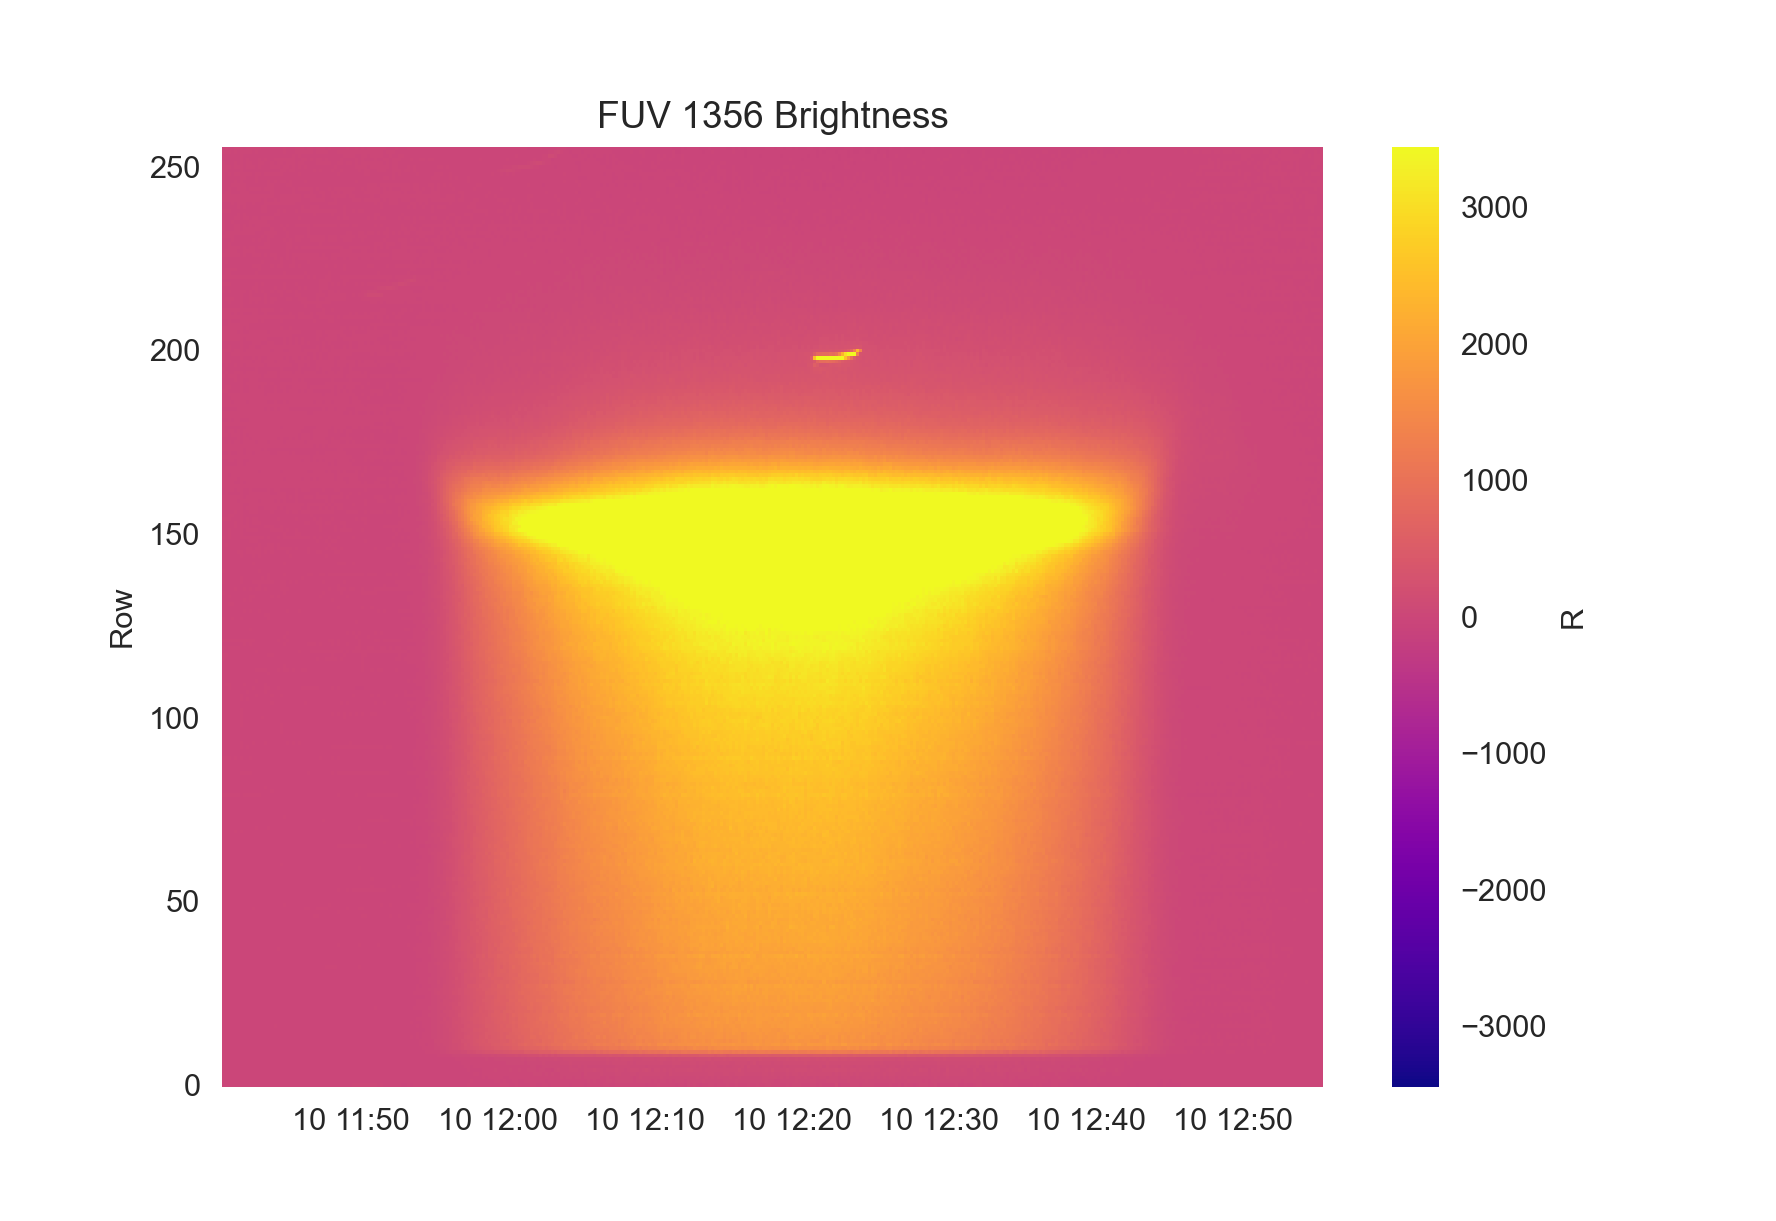

Text(0.5, 1.0, 'FUV 1356 Brightness')

In [24]:
# Raw orbit 7 plot
orbit1_data = p_0_all_orbits[7]

plt.figure()
vm = abs(orbit1_data.I_1356).quantile(0.95) # Choose max of colorbar (i.e., contrast)
plt.pcolormesh(pd.to_datetime(orbit1_data.time.values), orbit1_data.row, orbit1_data.I_1356.T, cmap='plasma', vmin=-vm, vmax=vm)
plt.ylabel('Row')
plt.colorbar(label='R')
plt.title('FUV 1356 Brightness')



<IPython.core.display.Javascript object>


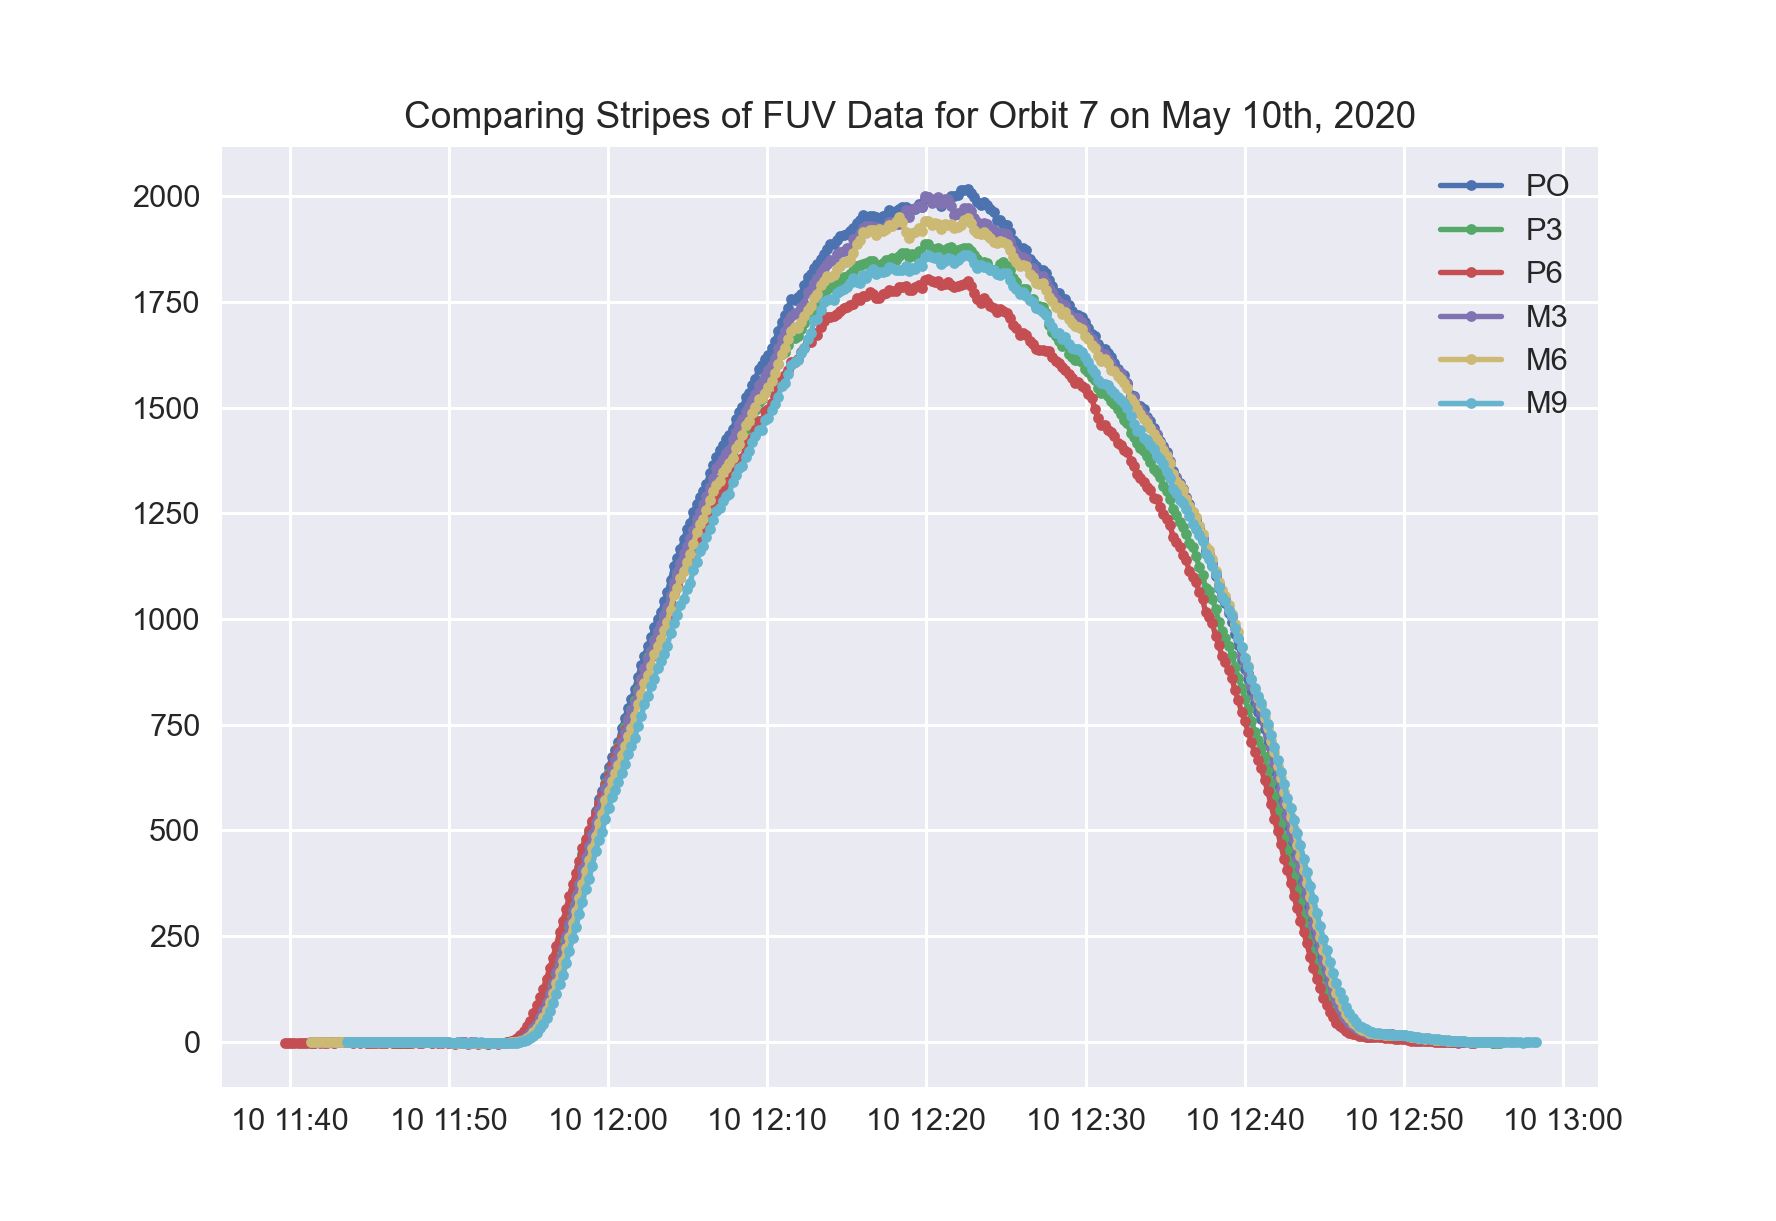

<IPython.core.display.Javascript object>


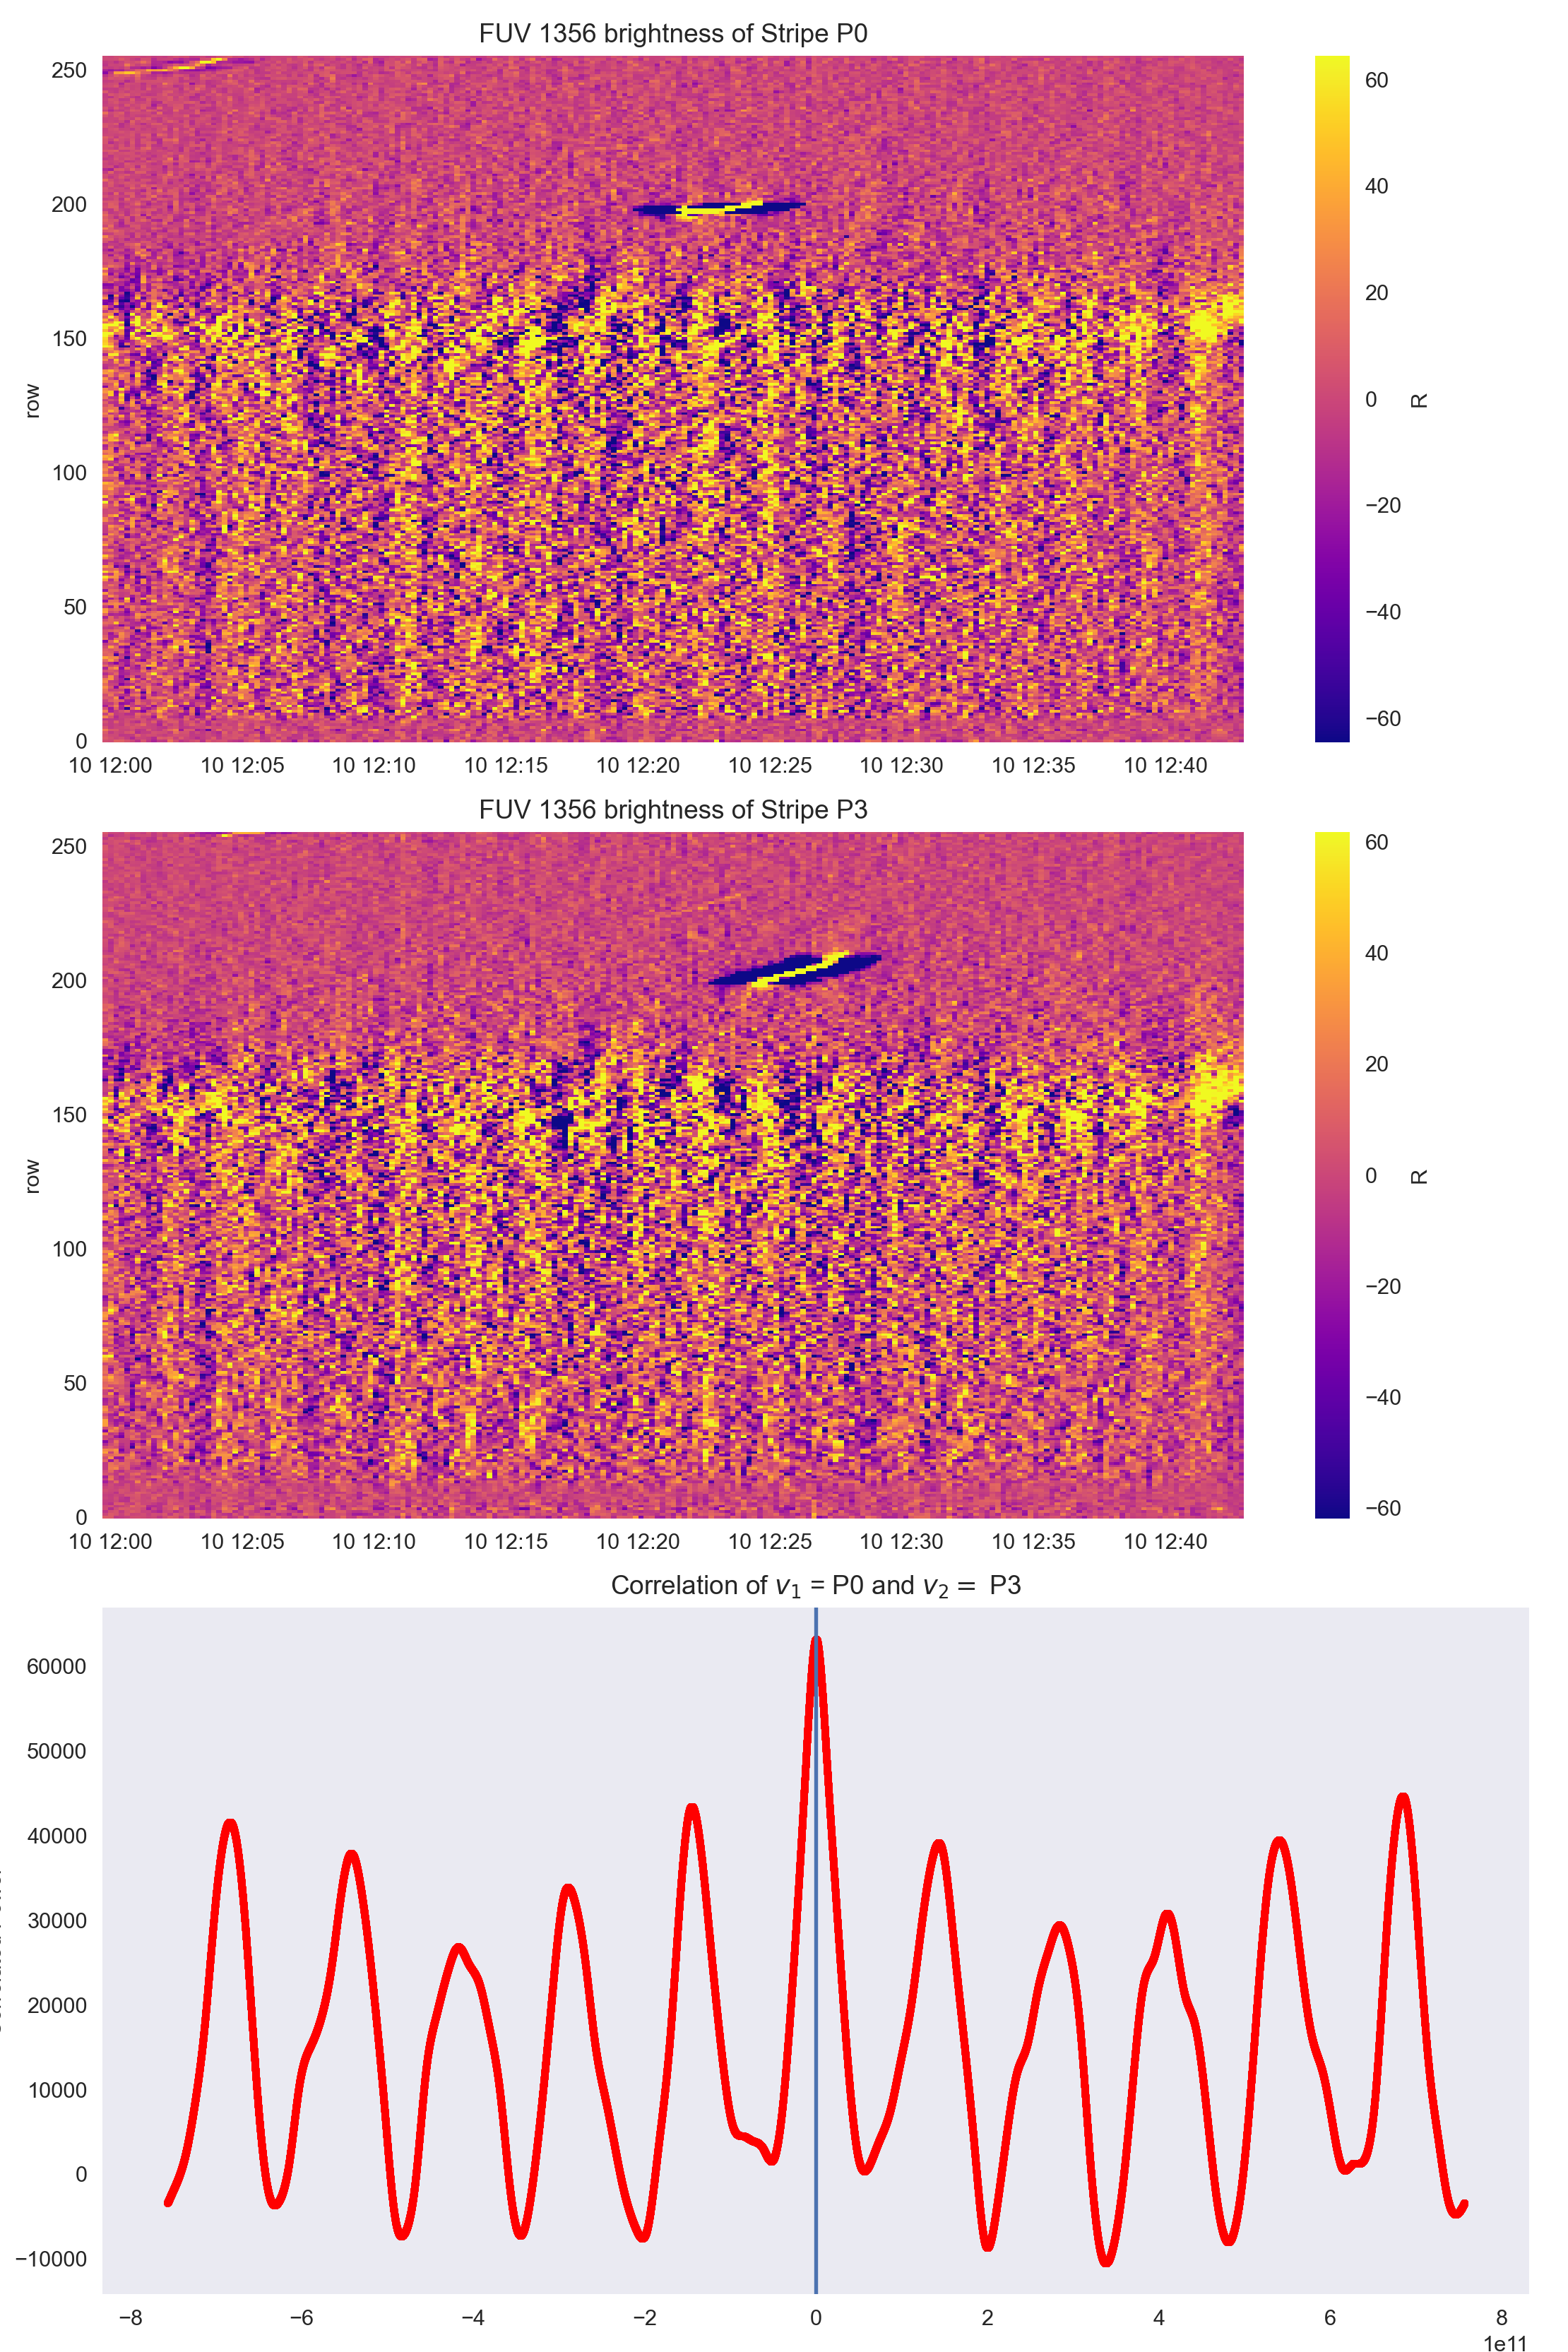

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


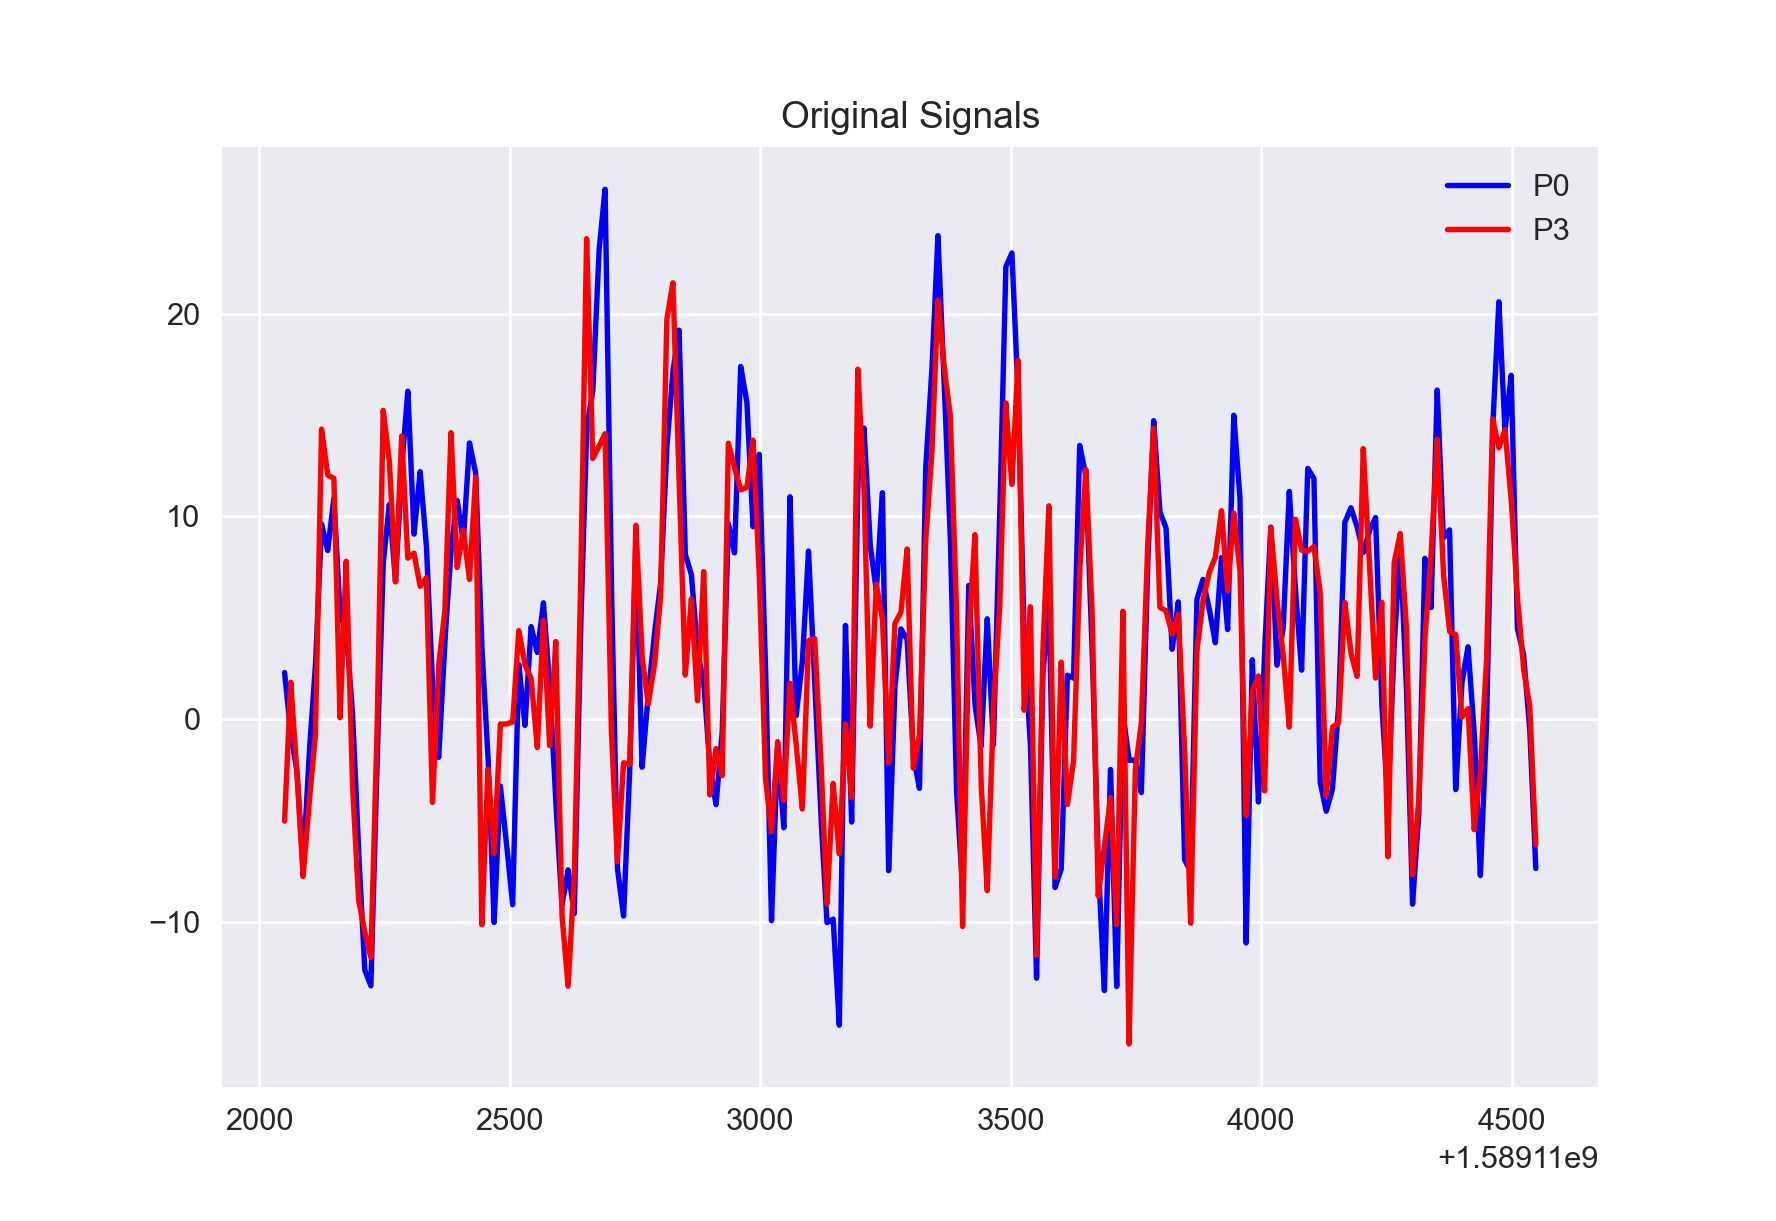

index 102047
xval 575261952.0000001
Difference from 0: 0.5752619520000002


<IPython.core.display.Javascript object>


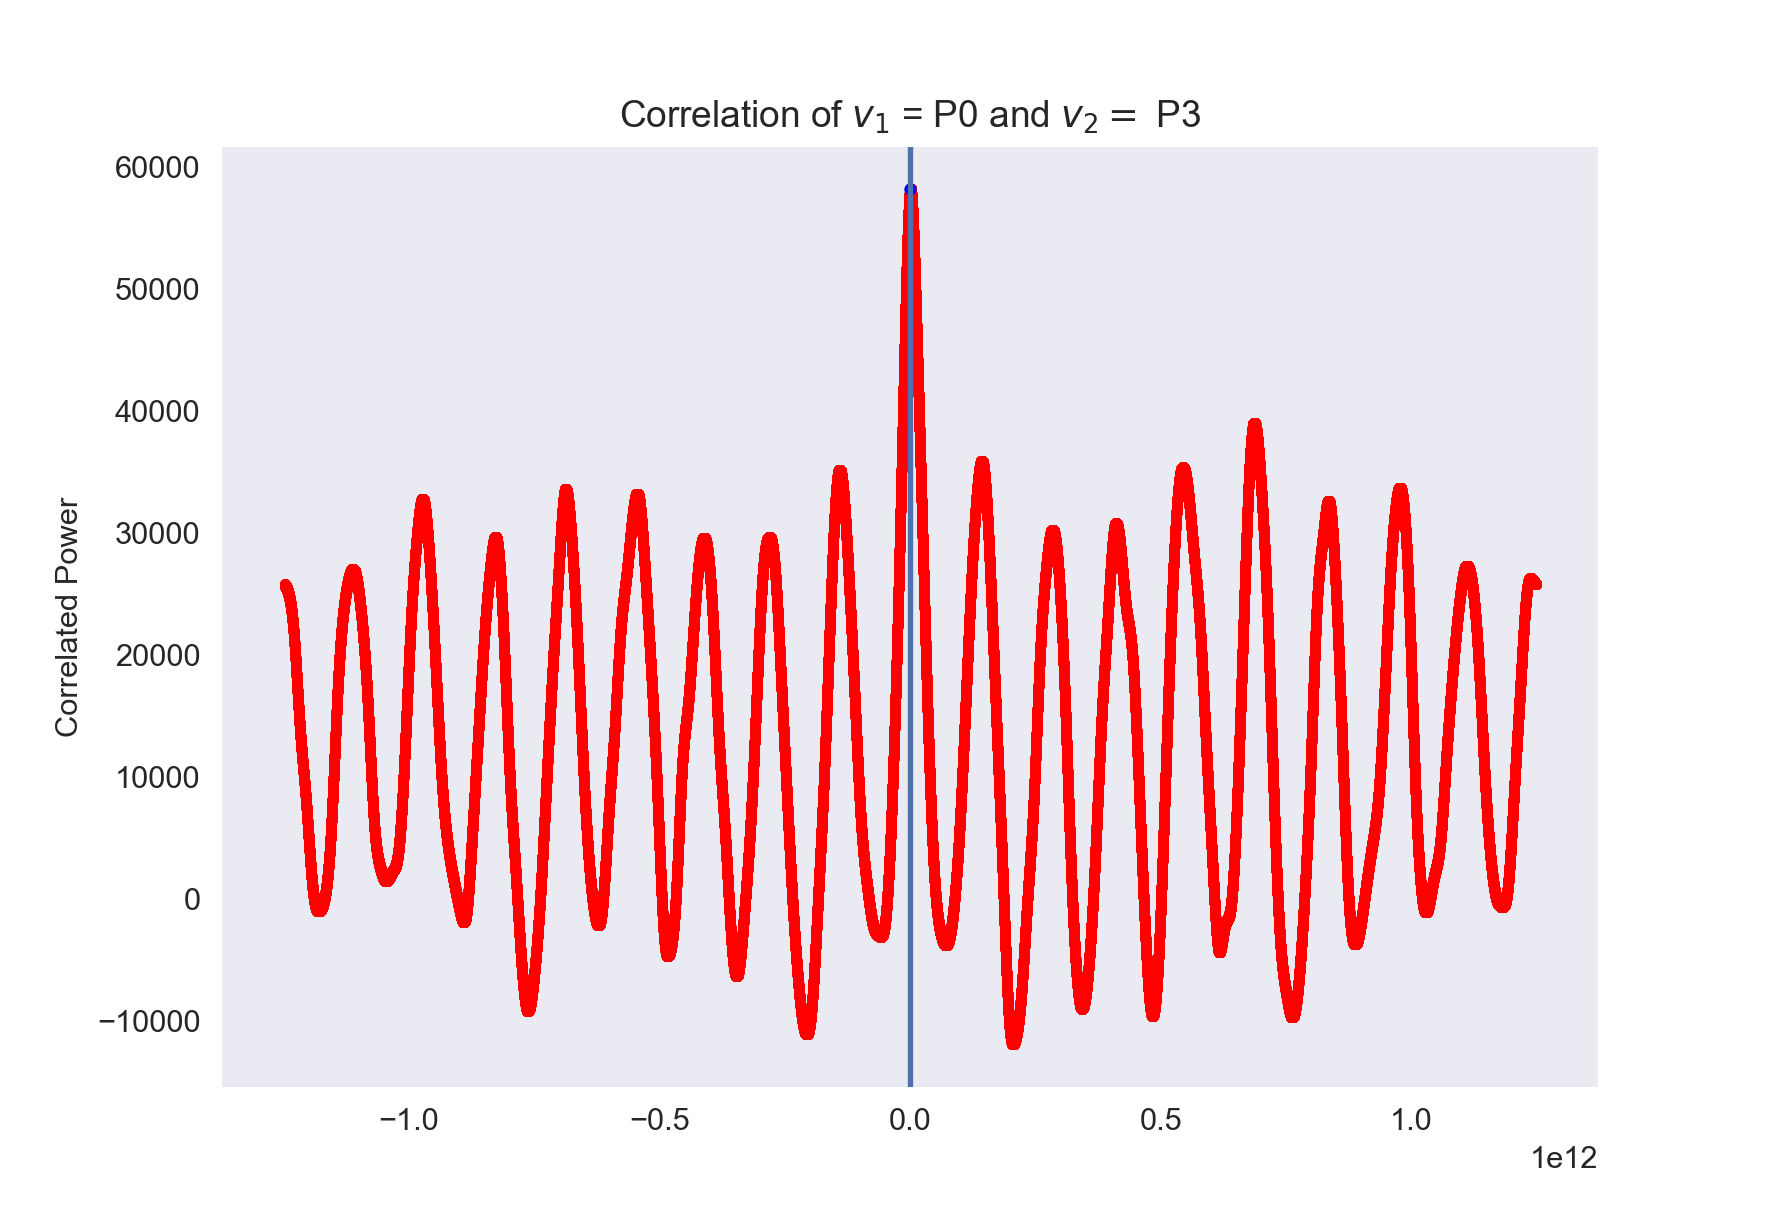

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


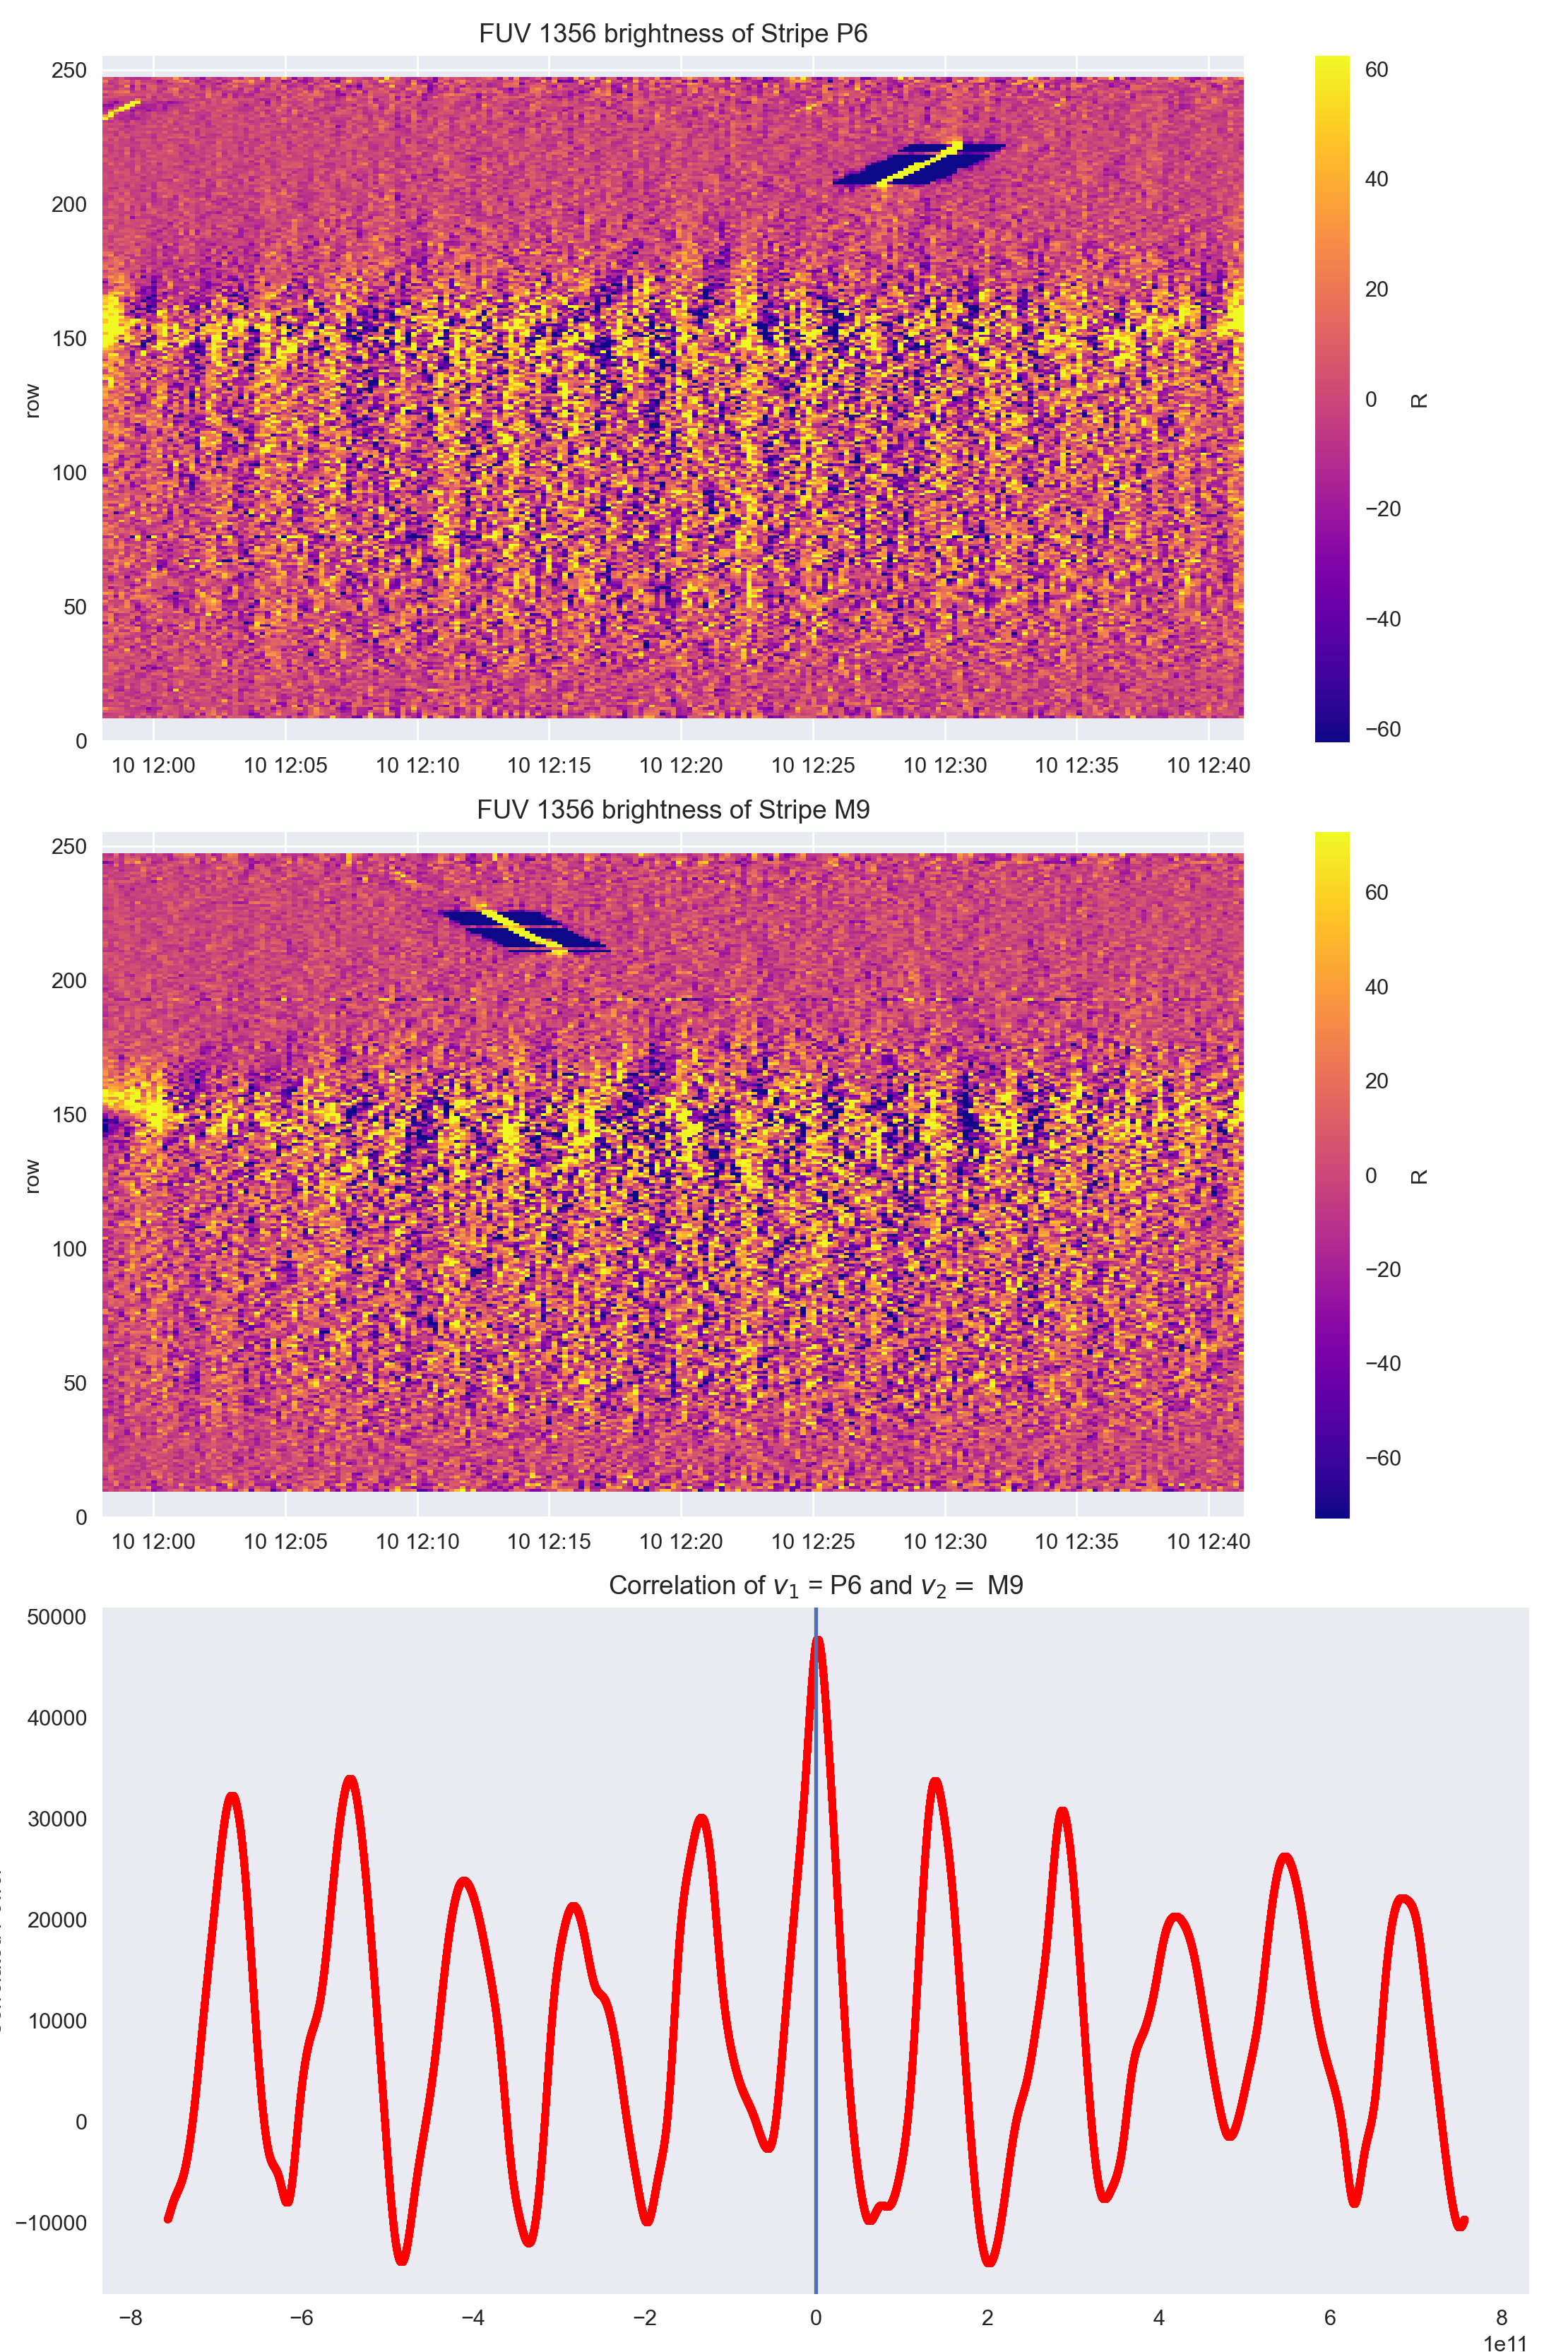

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


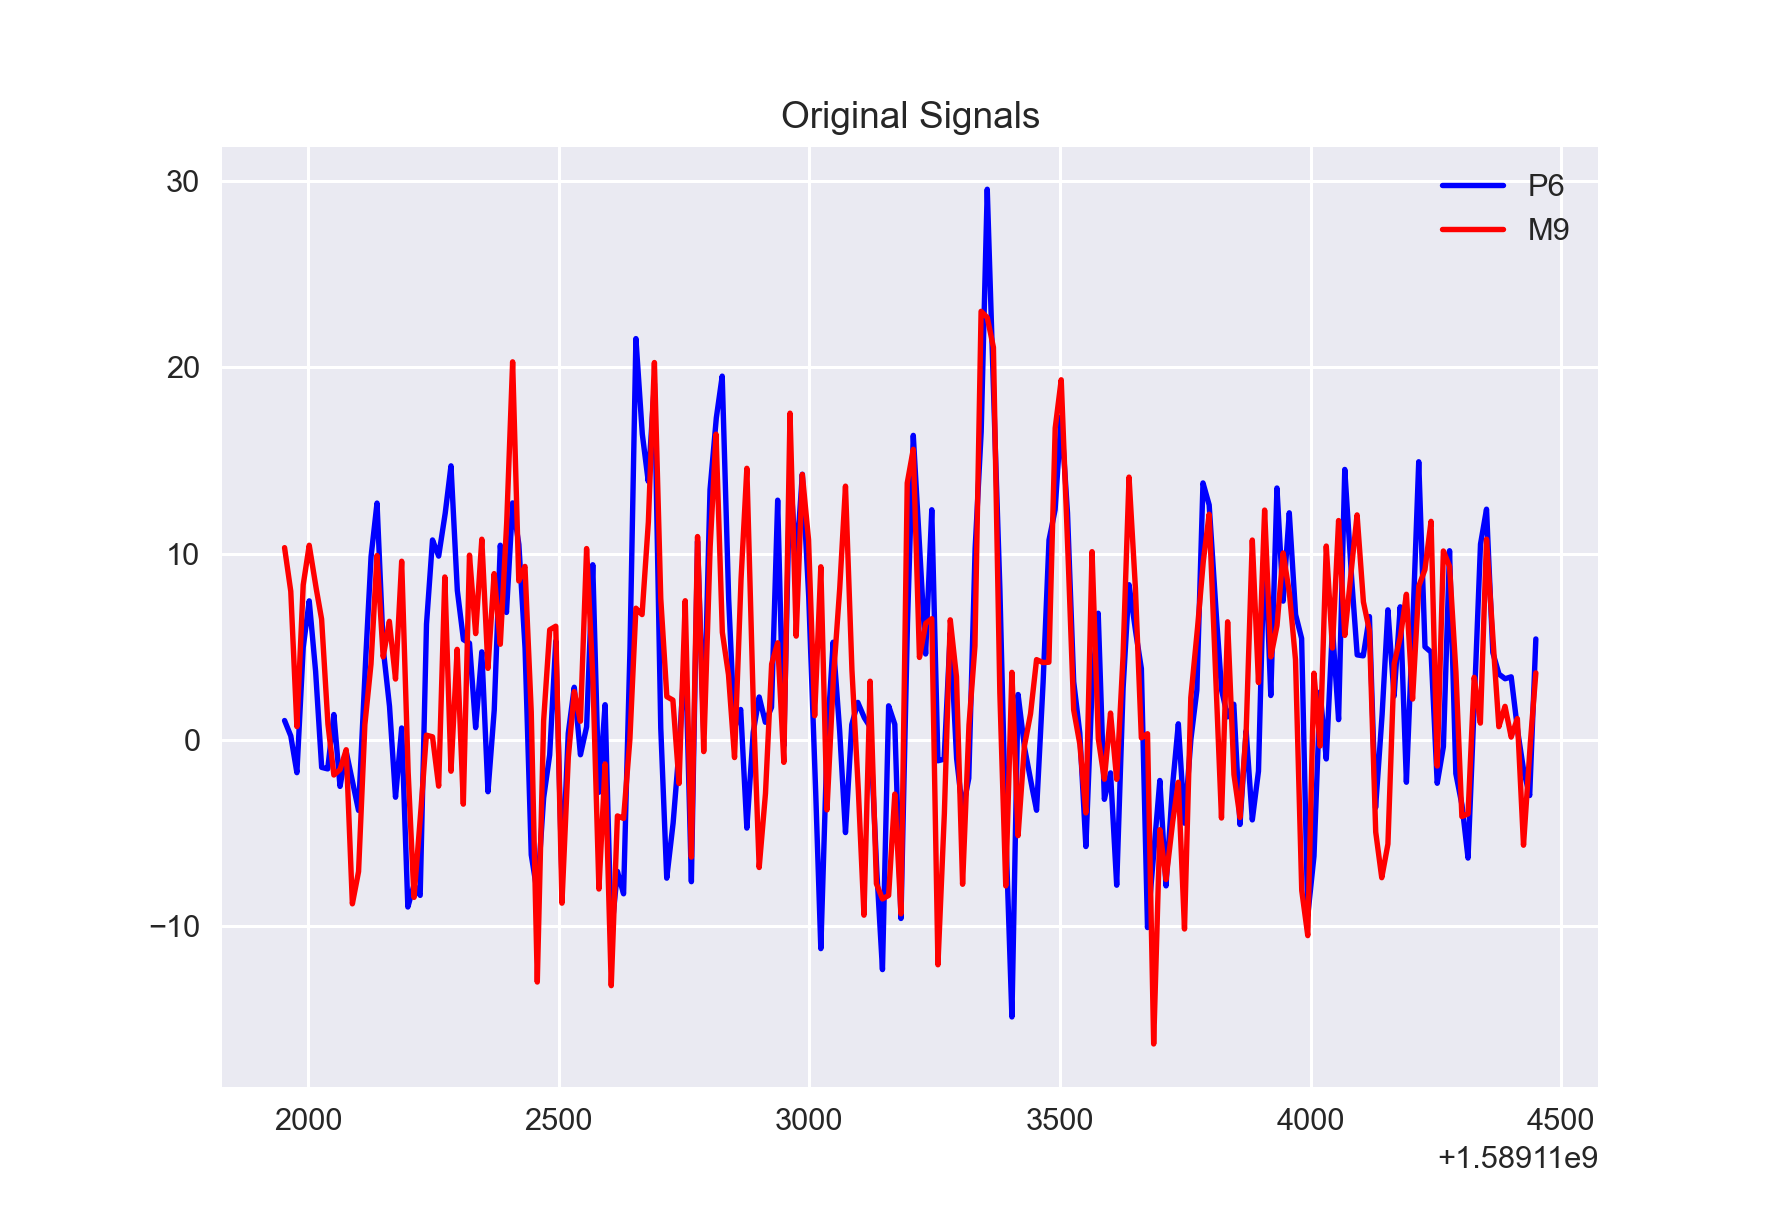

index 102040
xval 489584640.00000006
Difference from 0: 0.48958464000000007


<IPython.core.display.Javascript object>


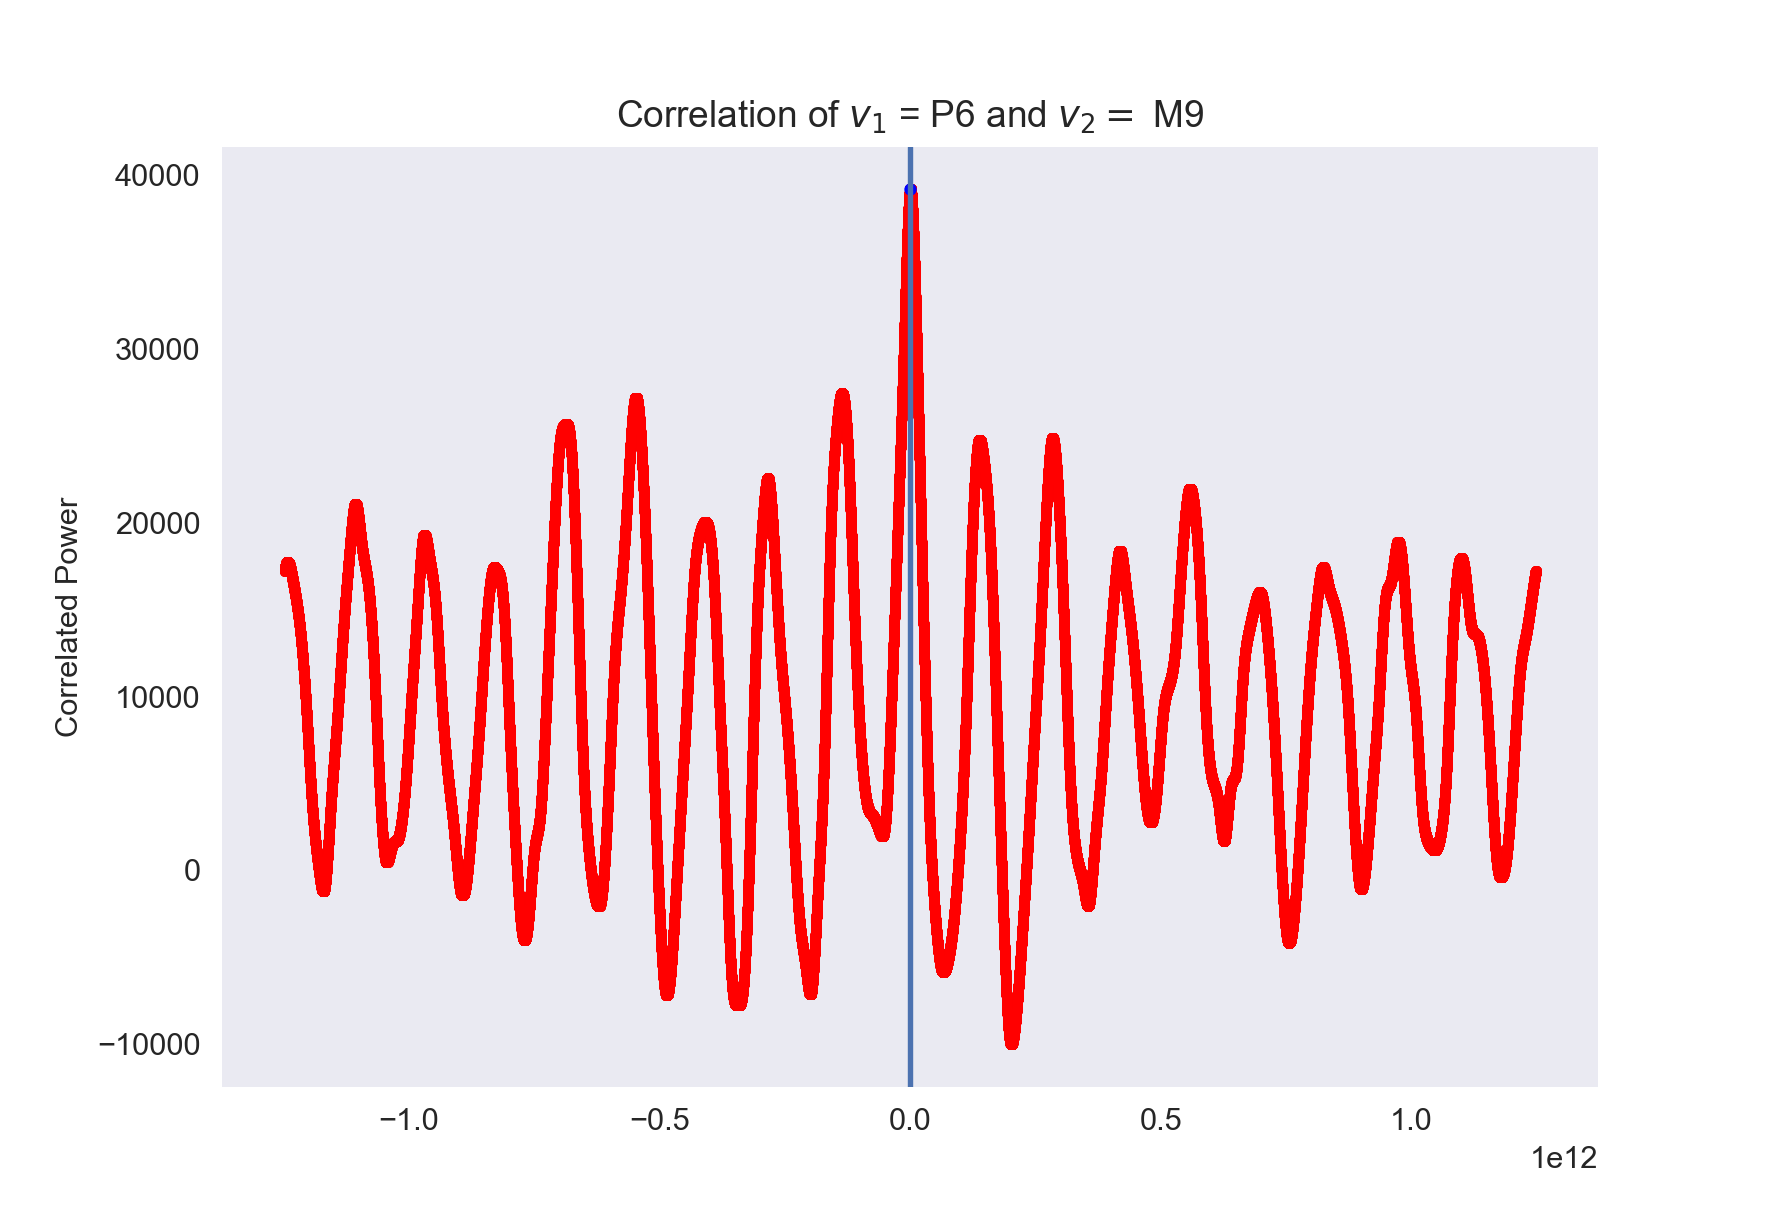

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


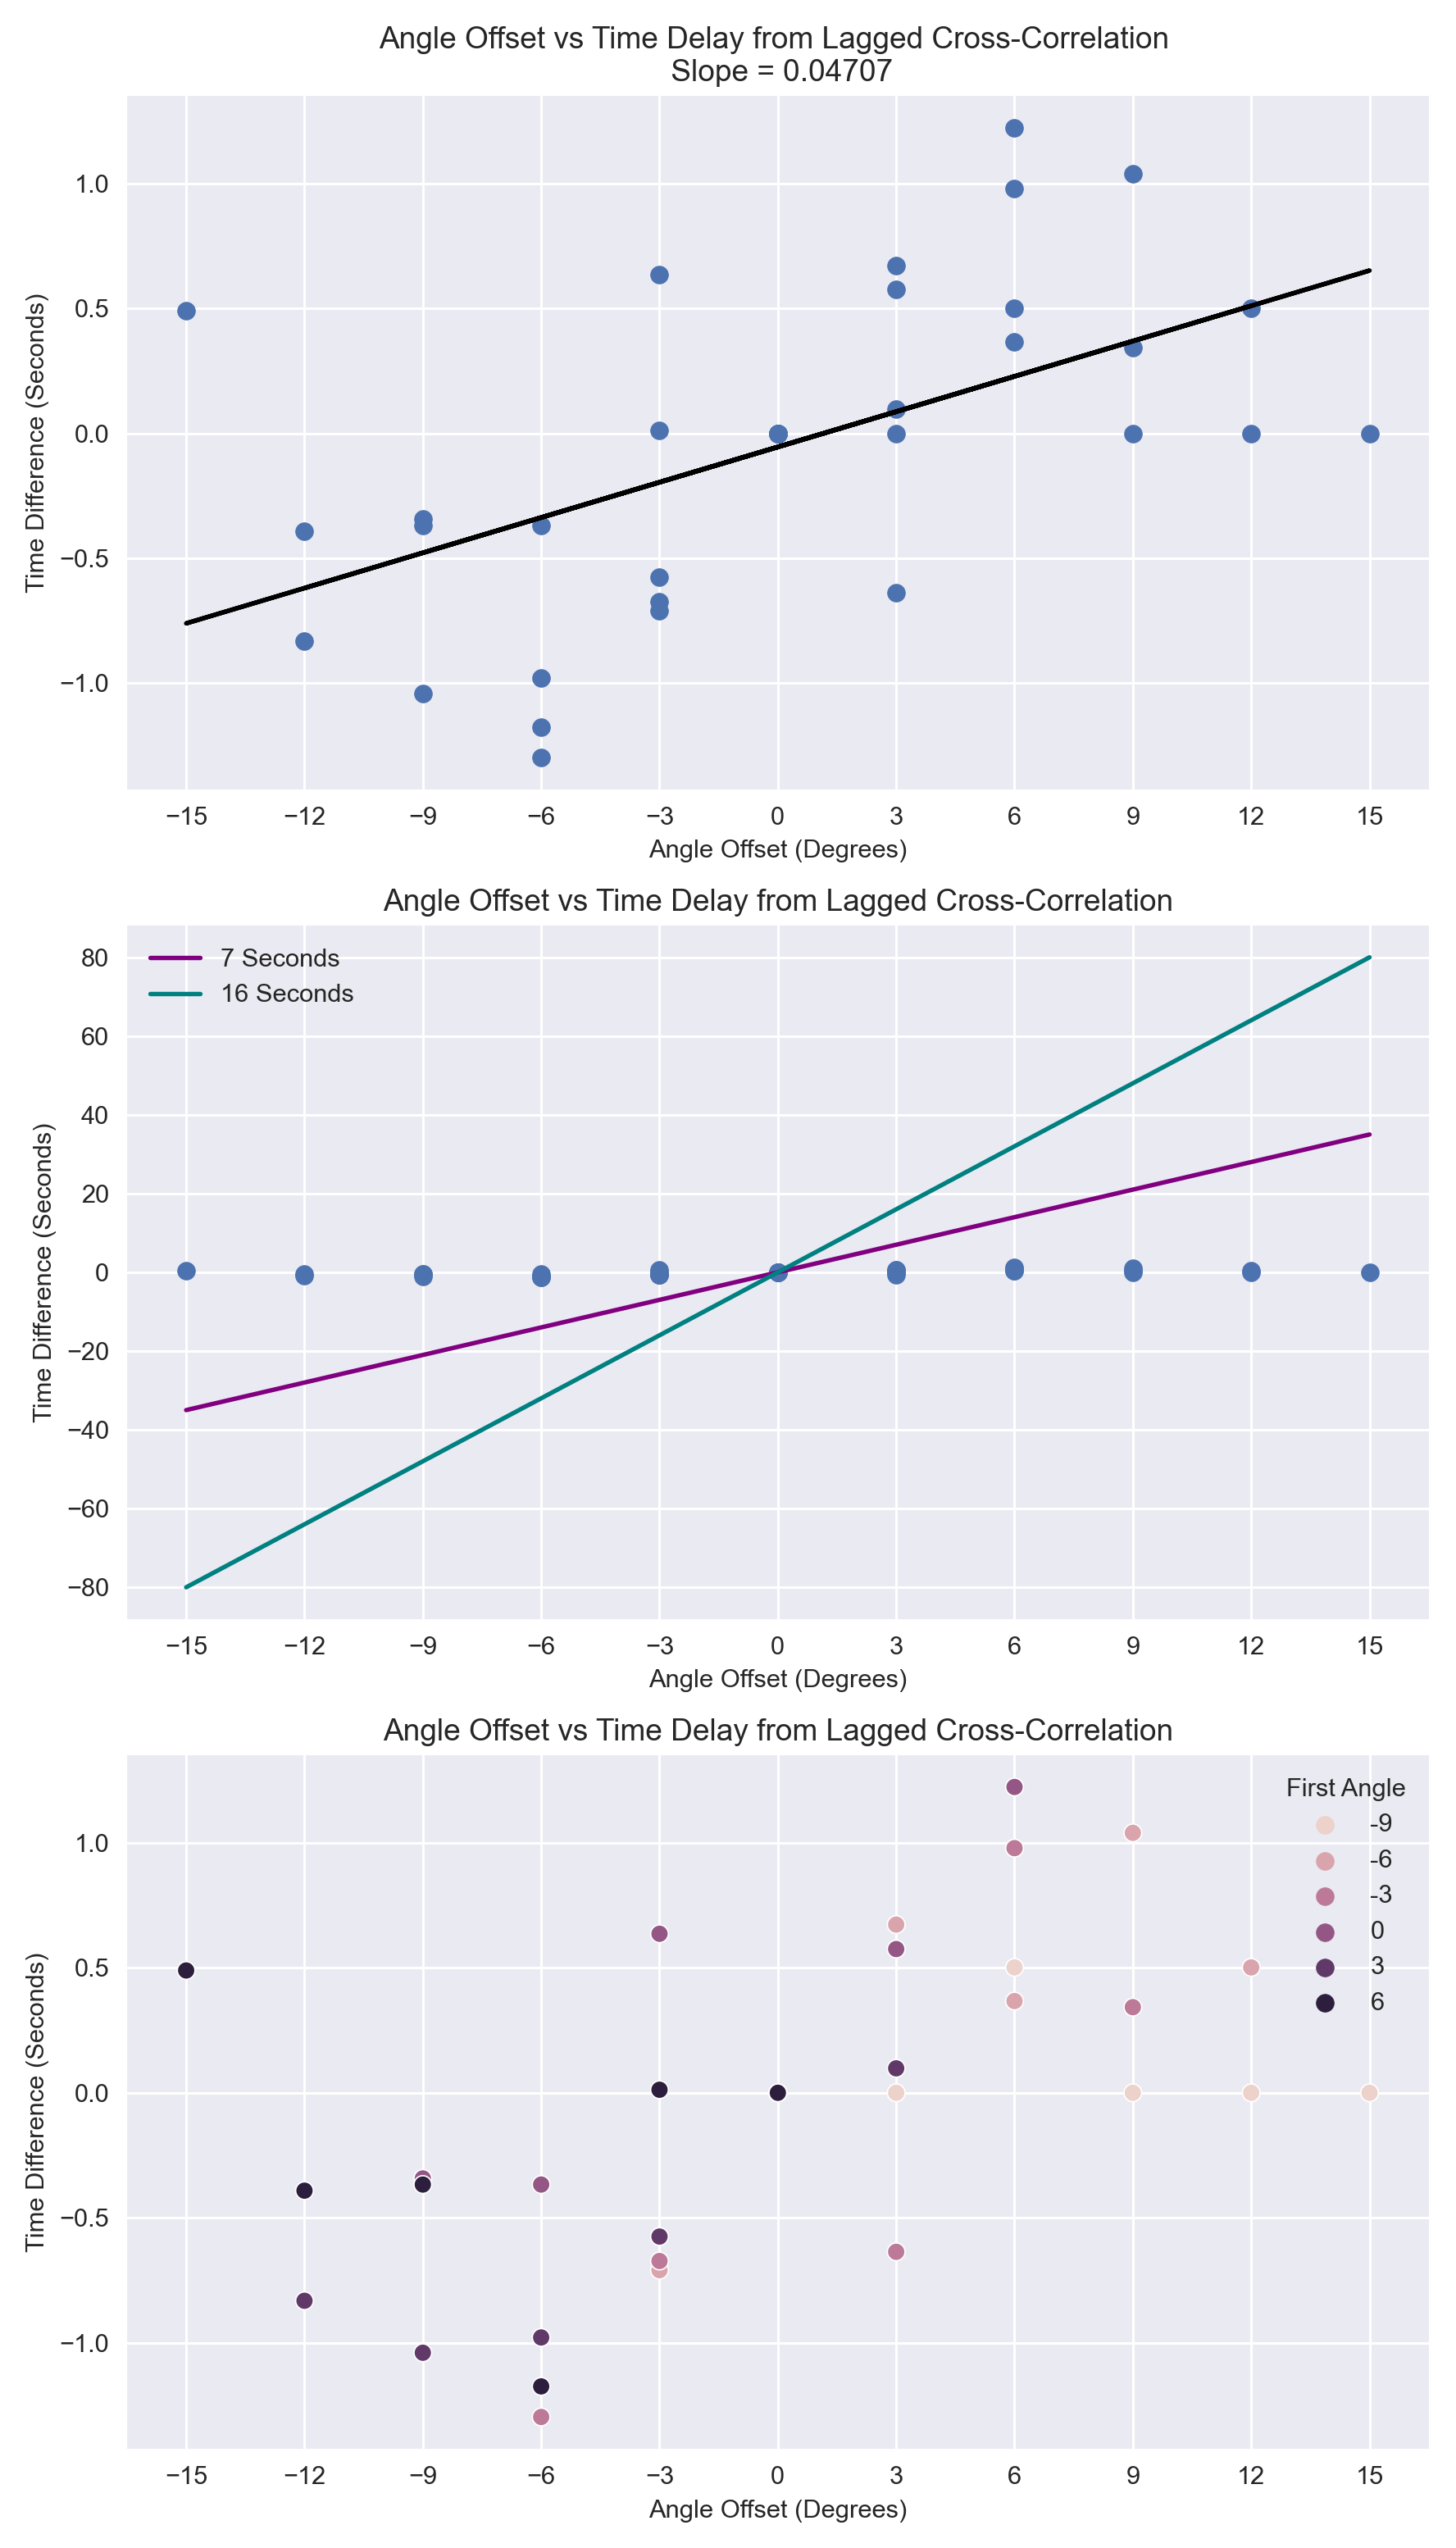

First Second  Difference  First Angle  Second Angle  Angle Diff  \
0     M9     M9    0.000000           -9            -9           0   
1     M9     M6    0.000000           -9            -6           3   
2     M9     M3    0.501824           -9            -3           6   
3     M9     P0    0.000000           -9             0           9   
4     M9     P3    0.000000           -9             3          12   
5     M9     P6    0.000000           -9             6          15   
6     M6     M9   -0.709898           -6            -9          -3   
7     M6     M6    0.000000           -6            -6           0   
8     M6     M3    0.673179           -6            -3           3   
9     M6     P0    0.367188           -6             0           6   
10    M6     P3    1.040367           -6             3           9   
11    M6     P6    0.501824           -6             6          12   
12    M3     M9   -1.297399           -3            -9          -6   
13    M3     M6   -0.673179           -3            -6          -3   
14    M3     M3    0.000000           -3            -3           0   
15    M3     P0   -0.636460           -3             0           3   
16    M3     P3    0.979169           -3             3           6   
17    M3     P6    0.342709           -3             6           9   
18    P0     M9   -0.342709            0            -9          -9   
19    P0     M6   -0.367188            0            -6          -6   
20    P0     M3    0.636460            0            -3          -3   
21    P0     P0    0.000000            0             0           0   
22    P0     P3    0.575262            0             3           3   
23    P0     P6    1.223962            0             6           6   
24    P3     M9   -0.832294            3            -9         -12   
25    P3     M6   -1.040367            3            -6          -9   
26    P3     M3   -0.979169            3            -3          -6   
27    P3     P0   -0.575262            3             0          -3   
28    P3     P3    0.000000            3             3           0   
29    P3     P6    0.097917            3             6           3   
30    P6     M9    0.489585            6            -9         -15   
31    P6     M6   -0.391668            6            -6         -12   
32    P6     M3   -0.367188            6            -3          -9   
33    P6     P0   -1.175003            6             0          -6   
34    P6     P3    0.012240            6             3          -3   
35    P6     P6    0.000000            6             6           0   

    Absolute Time Difference  
0                   0.000000  
1                   0.000000  
2                   0.501824  
3                   0.000000  
4                   0.000000  
5                   0.000000  
6                   0.709898  
7                   0.000000  
8                   0.673179  
9                   0.367188  
10                  1.040367  
11                  0.501824  
12                  1.297399  
13                  0.673179  
14                  0.000000  
15                  0.636460  
16                  0.979169  
17                  0.342709  
18                  0.342709  
19                  0.367188  
20                  0.636460  
21                  0.000000  
22                  0.575262  
23                  1.223962  
24                  0.832294  
25                  1.040367  
26                  0.979169  
27                  0.575262  
28                  0.000000  
29                  0.097917  
30                  0.489585  
31                  0.391668  
32                  0.367188  
33                  1.175003  
34                  0.012240  
35                  0.000000

In [38]:
everything(7)

In [36]:
slope(7)

0.04707395169523811